# Predicting Healthcare Insurance Costs

---

In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib as jb

---

### Retrieve Data

In [2]:
raw_data = pd.read_csv(r'Raw data\insurance.csv')

data = raw_data.copy()
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1284 non-null   object 
dtypes: float64(3), object(4)
memory usage: 73.3+ KB


In [4]:
data.describe()

,age,bmi,children
count,1272.000000,1272.000000,1272.000000
mean,35.214623,30.560550,0.948899
std,22.478251,6.095573,1.303532
min,-64.000000,15.960000,-4.000000
25%,24.750000,26.180000,0.000000
50%,38.000000,30.210000,1.000000
75%,51.000000,34.485000,2.000000
max,64.000000,53.130000,5.000000


---

### 1. Clean Data

In [5]:
data.isnull().sum()

age         66
sex         66
bmi         66
children    66
smoker      66
region      66
charges     54
dtype: int64

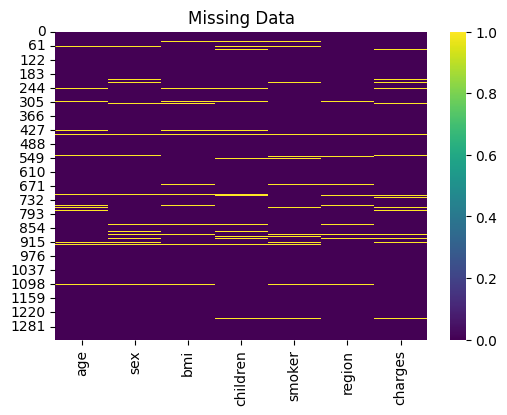

In [6]:
# Visualize missing data
plt.figure(figsize=(6,4))
sns.heatmap(data.isnull(), cbar=True, cmap="viridis")
plt.title("Missing Data")
plt.show()

In [7]:
mod_data = data.dropna()

mod_data['smoker'] = (mod_data['smoker'] == 'yes')
mod_data['sex'] = mod_data['sex'].apply(lambda x: 'male' if x in ['M', 'man', 'male'] else 'female')

mod_data = mod_data.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)

C:\Users\elkfrawy\AppData\Local\Temp\ipykernel_15780\4000539220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data['smoker'] = (mod_data['smoker'] == 'yes')
C:\Users\elkfrawy\AppData\Local\Temp\ipykernel_15780\4000539220.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data['sex'] = mod_data['sex'].apply(lambda x: 'male' if x in ['M', 'man', 'male'] else 'female')


##### Standardization for region

In [8]:
mod_data['region'] = mod_data['region'].str.lower()

##### Normalize charges data type and standardize it

In [9]:
mod_data['charges'] = mod_data['charges'].apply(lambda x: float(x[1:]) if x.startswith('$') else float(x))

In [10]:
mod_data['children'] = mod_data['children'].astype('int')

In [11]:
# Final View
mod_data.sample(10)

,age,sex,bmi,children,smoker,region,charges
858,25.0,female,32.230,1,False,southeast,18218.16139
934,32.0,male,37.180,2,False,southeast,4673.39220
261,20.0,female,26.840,1,True,southeast,17085.26760
137,22.0,male,25.175,0,False,northwest,2045.68525
212,24.0,male,28.500,2,False,northwest,3537.70300
232,19.0,female,17.800,0,False,southwest,1727.78500
1221,40.0,male,24.970,2,False,southeast,6593.50830
840,21.0,male,31.100,0,False,southwest,1526.31200
353,33.0,male,35.245,0,False,northeast,12404.87910
724,50.0,female,27.075,1,False,northeast,10106.13425


In [12]:
mod_data.to_csv(r'Cleaned data\clean_data.csv')

---

### 2. Reviewing Relationships

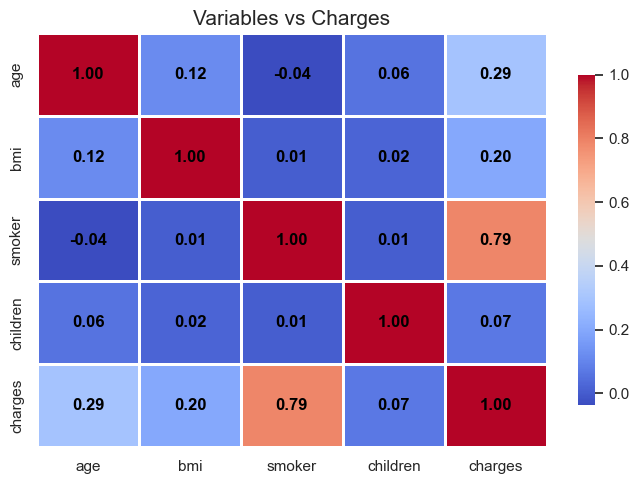

In [81]:
df = mod_data.copy()

# Calculate the correlation matrix
correlation_matrix = df[["age", "bmi", 'smoker', "children", "charges"]].corr()

# Set the plot style
sns.set(style="whitegrid", palette="muted")

# Create the heatmap
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=1, 
    linecolor="white", 
    cbar_kws={"shrink": 0.8}, 
    annot_kws={"size": 12, "weight": "bold", "color": "black"}
)

# Title and aesthetics
plt.title("Variables vs Charges", fontsize=15)
plt.tight_layout()
plt.show()

---

### 3. Data Preprocessing

In [189]:
def preprocess(df):
    df_new = pd.get_dummies(df, prefix=['region'], columns=['region'])
    df_new = df_new.drop(columns=['region_southeast'])
    
    df_new['smoker'] = (df_new['smoker'] == 'yes')
    df_new['smoker'] = df_new['smoker'].astype('int')

    df_new['is_male'] = (df_new['sex'] == 'male').astype('int')
    df_new = df_new.drop(columns=['sex'])
    
    return df_new

In [156]:
df_new = pd.get_dummies(df, prefix=['region'], columns=['region'])
df_new = df_new.drop(columns=['region_southeast'])

df_new['smoker'] = df_new['smoker'].astype('int')

df_new['is_male'] = (df_new['sex'] == 'male').astype('int')
df_new = df_new.drop(columns=['sex'])

df_new.dropna(inplace=True)

---

### 4. Model Training

In [171]:
X = df_new.drop(columns=['charges'])
y = df_new['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

In [172]:
# Evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R² Score": r2
    })

In [177]:
results_df = pd.DataFrame(results)

print("Model Evaluation Results:")
results_df

Model Evaluation Results:


,Model,MAE,MSE,RMSE,R² Score
0,Linear Regression,4378.723563,3.993661e+07,6319.542180,0.704932
1,Ridge Regression,4387.325110,3.987363e+07,6314.556634,0.705398
2,Lasso Regression,4378.677319,3.993587e+07,6319.482997,0.704938
3,Decision Tree,3231.647531,4.619788e+07,6796.902598,0.658672
4,Random Forest,2875.118280,2.388468e+07,4887.195539,0.823530


**It seems that *random forests* do perform well with our data**

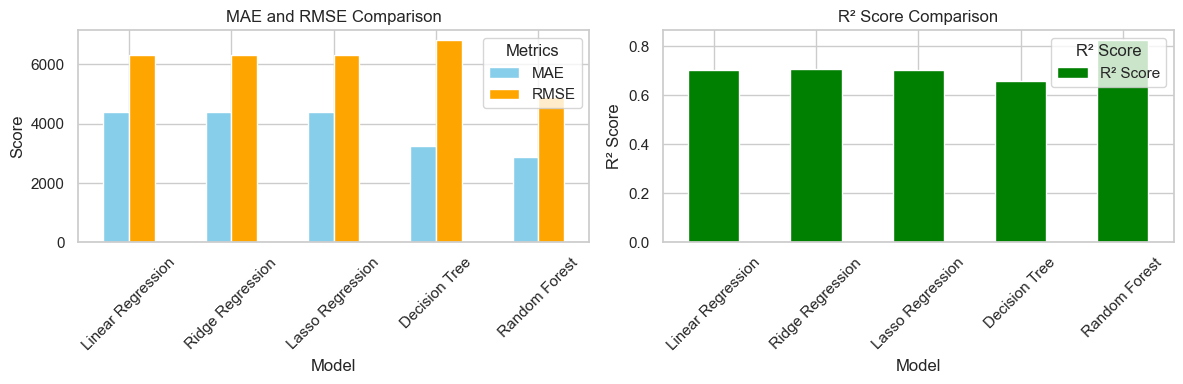

In [178]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Plot MAE and RMSE
metrics_plot = results_df.set_index("Model")[["MAE", "RMSE"]]
metrics_plot.plot(kind="bar", ax=axes[0], color=['skyblue', 'orange'])
axes[0].set_title("MAE and RMSE Comparison")
axes[0].set_ylabel("Score")
axes[0].set_xticklabels(metrics_plot.index, rotation=45)
axes[0].legend(title="Metrics")

# Plot R² Score
r2_plot = results_df.set_index("Model")[["R² Score"]]
r2_plot.plot(kind="bar", ax=axes[1], color='green')
axes[1].set_title("R² Score Comparison")
axes[1].set_ylabel("R² Score")
axes[1].set_xticklabels(r2_plot.index, rotation=45)
axes[1].legend(title="R² Score")

# Adjust layout
plt.tight_layout()
plt.show()

### 5. Fine tune the model

In [180]:
chosen_model_name = "Random Forest"
chosen_model = models[chosen_model_name]

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [181]:
# Grid Search for hyperparameter tuning
grid_search = GridSearchCV(estimator=chosen_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters for {chosen_model_name}:")
print(best_params)

Fine-tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [182]:
# Evaluate the fine-tuned model
y_pred_tuned = best_model.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Performance of Fine-Tuned Model:")
print(f"MAE: {mae_tuned:.2f}")
print(f"MSE: {mse_tuned:.2f}")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"R² Score: {r2_tuned:.2f}")

Performance of Fine-Tuned Model:
MAE: 2644.89
MSE: 20776925.52
RMSE: 4558.17
R² Score: 0.85


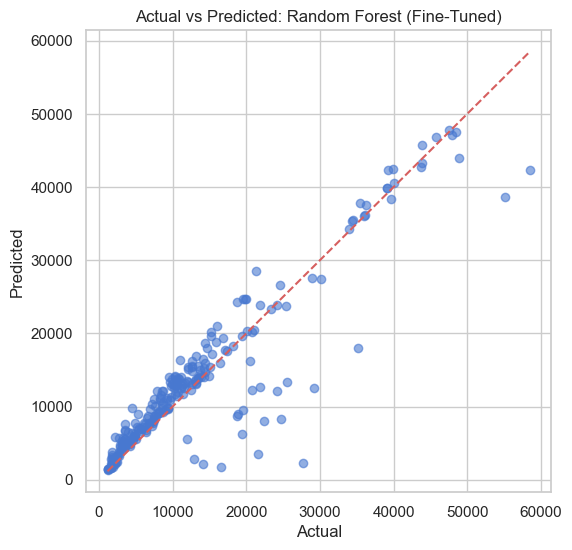

In [183]:
# Visualize prediction vs actual for the fine-tuned model
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Actual vs Predicted: {chosen_model_name} (Fine-Tuned)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

---

### 6. Saving model

In [185]:
jb.dump(chosen_model, r'Prediction model\rd_model.pkl')

['Prediction model\\rd_model.pkl']

---

### Using The Model

In [186]:
predict_model = jb.load(r'Prediction model\rd_model.pkl')

In [192]:
val_df = pd.read_csv(r'Raw data\validation_dataset.csv')
input_df = preprocess(val_df)

predictions = predict_model.predict(input_df)
validation_data = val_df.copy()

validation_data['predicted_charges'] = predictions

validation_data.head()

,age,sex,bmi,children,smoker,region,predicted_charges
0,18.0,female,24.090000,1.0,no,southeast,2584.927270
1,39.0,male,26.410000,0.0,yes,northeast,21113.755964
2,27.0,male,29.150000,0.0,yes,southeast,18601.582481
3,71.0,male,65.502135,13.0,yes,southeast,58661.263088
4,28.0,male,38.060000,0.0,no,southeast,6933.356463
